In [2]:
!nvidia-smi

Tue Aug 19 17:48:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8             10W /   95W |     138MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# STEP 1: Import Required Libraries

In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
import random
from PIL import Image, ImageFilter
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Check if CUDA is available
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
torch.manual_seed(0)

Using device: cuda
PyTorch version: 2.8.0+cu126


# STEP 2: Load and Explore the Dataset

In [5]:
path = "./competition"
print("Path to dataset files:", path)

TRAIN_DIR = os.path.join(path, "train")
TRAIN_CSV = os.path.join(path, "train_labels.csv")
TEST_DIR = os.path.join(path, "test")
SUBMISSION = os.path.join(path, "submission.csv")

LABELS = ['basophil','eosinophil','erythroblast','immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
		  'lymphocyte','monocyte','neutrophil','platelet']
LABEL2IDX = {label: idx for idx, label in enumerate(LABELS)}
IDX2LABEL = {idx: label for label, idx in LABEL2IDX.items()}

Path to dataset files: ./competition


In [6]:
print(TRAIN_DIR)
print(TRAIN_CSV)
print(TEST_DIR)
print(SUBMISSION)

./competition\train
./competition\train_labels.csv
./competition\test
./competition\submission.csv


# STEP 3: Custom Dataset Class

In [7]:
class ArtDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, is_test=False):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
        self.has_labels = 'label' in self.data.columns and not is_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename = self.data.iloc[idx]['filename']
        img_path = os.path.join(self.img_dir, filename)  # no f-string needed

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new("RGB", (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        if self.has_labels:
            label = int(self.data.iloc[idx]['label'])  # already numeric
            return image, label
        else:
            return image, filename

# STEP 5: Data Transforms and Augmentation

In [12]:
def pad_to_square(img):
    w, h = img.size
    max_wh = max(w, h)
    pad_w = (max_wh - w) // 2
    pad_h = (max_wh - h) // 2
    padding = (pad_w, pad_h, max_wh - w - pad_w, max_wh - h - pad_h)
    return TF.pad(img, padding, padding_mode='symmetric')

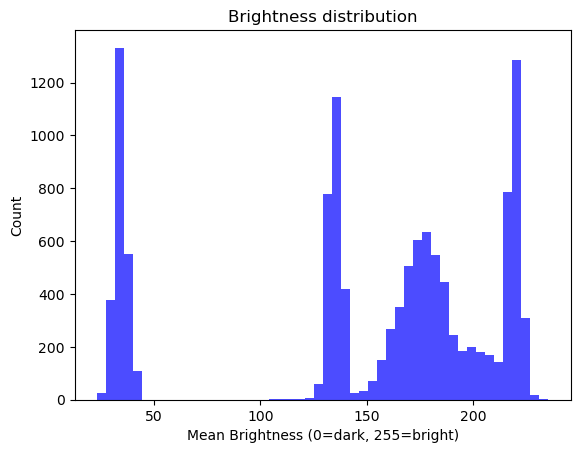

In [9]:
def get_mean_brightness(img_path):
    img = Image.open(img_path).convert("L")
    return np.array(img).mean()

brightness_vals = []
for fname in os.listdir(TRAIN_DIR):
    if fname.endswith(".jpg") or fname.endswith(".png"):
        brightness_vals.append(get_mean_brightness(os.path.join(TRAIN_DIR, fname)))

plt.hist(brightness_vals, bins=50, color='blue', alpha=0.7)
plt.xlabel("Mean Brightness (0=dark, 255=bright)")
plt.ylabel("Count")
plt.title("Brightness distribution")
plt.show()

In [10]:
def gamma_to_hit_target(mean_brightness, target=140, clamp=(0.6, 1.6), blend=0.6):
    """
    mean_brightness, target in [0..255]
    clamp: min/max gamma
    blend: 0..1, 1 = use full gamma*, 0 = no change (gamma=1)
    """
    m = np.clip(mean_brightness/255.0, 1e-4, 1-1e-4)
    t = np.clip(target/255.0,         1e-4, 1-1e-4)
    gamma_star = np.log(t)/np.log(m)                 # exact power-law match
    gamma_star = float(np.clip(gamma_star, *clamp))  # safety clamp
    gamma = 1.0*(1-blend) + gamma_star*blend         # soften the correction
    return gamma

def adjust_gamma_auto(img, low_thresh=60, high_thresh=165, target=140, tolerance=25):
    mean_brightness = np.array(img.convert("L")).mean()
    if mean_brightness < target - tolerance and mean_brightness < low_thresh:
        gamma = gamma_to_hit_target(mean_brightness, target, clamp=(0.55, 1.1), blend=0.8)  # brighten
        return TF.adjust_gamma(img, gamma, gain=1.0)
    elif mean_brightness > target + tolerance and mean_brightness > high_thresh:
        gamma = gamma_to_hit_target(mean_brightness, target, clamp=(0.9, 1.6), blend=0.8)   # darken
        return TF.adjust_gamma(img, gamma, gain=1.0)
    else:
        return img

In [34]:
def compute_avg_hist(image_paths, size=(224,224)):
    hists = []
    for p in tqdm(image_paths):
        img = Image.open(p).convert("RGB").resize(size)
        np_img = np.array(img)
        hist = []
        for c in range(3):  # R,G,B
            h, _ = np.histogram(np_img[...,c], bins=256, range=(0,256))
            h = h.astype(np.float32) / np.sum(h)
            hist.append(h)
        hists.append(hist)
    # average histogram per channel
    avg_hist = [np.mean([h[c] for h in hists], axis=0) for c in range(3)]
    return avg_hist

In [36]:
train_images = [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) if f.endswith((".png",".jpg",".jpeg"))]
test_images  = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) if f.endswith((".png",".jpg",".jpeg"))]

train_hist = compute_avg_hist(train_images)
test_hist  = compute_avg_hist(test_images)

train_cdfs = [np.cumsum(h)/np.sum(h) for h in train_hist]
test_cdfs  = [np.cumsum(h)/np.sum(h) for h in test_hist]

# LUT mapping train→test
lut = []
for c in range(3):
    mapping = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        val = train_cdfs[c][i]
        j = np.argmin(np.abs(test_cdfs[c] - val))
        mapping[i] = j
    lut.append(mapping)

100%|██████████| 3421/3421 [00:31<00:00, 109.63it/s]


In [37]:
def apply_histogram_map(img, lut):
    np_img = np.array(img)
    for c in range(3):  # R, G, B
        np_img[..., c] = lut[c][np_img[..., c]]
    return Image.fromarray(np_img.astype(np.uint8))

In [99]:
class CustomAugment:
    def __init__(self, size=(224,224), p_flip=0.5, p_vflip=0.2,
                 p_blur=0.3, p_saltpepper=0.3, p_cutout=0.3,
                 auto_gamma=True, hist_map=None):
        """
        hist_map: (optional) LUT from train→test hist (list of 3 arrays)
        """
        self.size = size
        self.p_flip = p_flip
        self.p_vflip = p_vflip
        self.p_blur = p_blur
        self.p_saltpepper = p_saltpepper
        self.p_cutout = p_cutout
        self.auto_gamma = auto_gamma
        self.hist_map = hist_map

        self.color_jitter = transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
        )

    def __call__(self, img):
        if not isinstance(img, Image.Image):
            img = TF.to_pil_image(img)

        # Histogram map first (if enabled)
        if self.hist_map is not None:
            img = apply_histogram_map(img, self.hist_map)

        # rest of your augmentations
        if random.random() < self.p_flip:
            img = TF.hflip(img)
        if random.random() < self.p_vflip:
            img = TF.vflip(img)

        max_translate = 0.1
        translate = (
            random.uniform(-max_translate, max_translate) * img.width,
            random.uniform(-max_translate, max_translate) * img.height
        )
        angle = random.uniform(-15, 15)
        scale = random.uniform(0.9, 1.1)
        shear = random.uniform(-5, 5)
        img = TF.affine(img, angle=angle, translate=translate, scale=scale, shear=shear)

        img = TF.resize(img, self.size)
        img = self.color_jitter(img)

        if random.random() < self.p_blur:
            img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))

        if self.auto_gamma:
            img = adjust_gamma_auto(img, low_thresh=60, high_thresh=165, target=140, tolerance=25)

        img = pad_to_square(img)

        if random.random() < self.p_saltpepper:
            img = self.add_salt_pepper(img, amount=0.005)

        if random.random() < self.p_cutout:
            img = self.apply_cutout(img)

        return img

    def add_salt_pepper(self, img, amount=0.005):
        np_img = np.array(img)
        num_salt = np.ceil(amount * np_img.size * 0.5)
        num_pepper = np.ceil(amount * np_img.size * 0.5)

        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in np_img.shape[:2]]
        np_img[coords[0], coords[1]] = 255
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in np_img.shape[:2]]
        np_img[coords[0], coords[1]] = 0

        return Image.fromarray(np_img.astype(np.uint8))

    def apply_cutout(self, img):
        np_img = np.array(img)
        H, W, _ = np_img.shape

        mean_color = np.mean(np_img, axis=(0, 1)).astype(np.uint8)

        cut_w = random.randint(W // 4, W // 2)
        cut_h = random.randint(H // 4, H // 2)

        cx = random.randint(0, W - 1)
        cy = random.randint(0, H - 1)

        x1 = max(cx - cut_w // 2, 0)
        y1 = max(cy - cut_h // 2, 0)
        x2 = min(cx + cut_w // 2, W)
        y2 = min(cy + cut_h // 2, H)

        np_img[y1:y2, x1:x2, :] = mean_color
        return Image.fromarray(np_img.astype(np.uint8))

In [91]:
# ImageNet
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
# b0
size = (224, 224)
# b3
# size = (300, 300)

train_transforms = transforms.Compose([
    CustomAugment(size=size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize(size=size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [92]:
# Load the training data and split it into train/validation
train_data = pd.read_csv(TRAIN_CSV)

In [81]:
print(train_data)

                                          filename  label
0     95cefacab2395b48dddf2dc3a7baac967c4f1fb7.png      7
1     6c948842a3848dd022c209ad714d2cbeb54a8e13.png      6
2     e9250499282e0a327f7226acf53884b26b9ae3c0.png      3
3     75f79956248935d03203129803bf50e08295a871.png      3
4     b18ce60f5292831c7a838939562fe6441d61d331.png      6
...                                            ...    ...
9375  10a65a8c4229bb34a46813917706f41954e971e6.png      6
9376  9d78d9c61c690e7e0212c50e7c88d0d5f11afa92.png      6
9377  6647d2dd4516b6e89ed22335d1be4e89ae06b69e.png      6
9378  4ab8e05e893cfa76251f2aec801ee9e5a2ac77f9.png      7
9379  b2c26da3e57186a40d51ed3740ea7a72fc7c1a8f.png      1

[9380 rows x 2 columns]


# STEP 6: Create Data Loaders

In [93]:
# Split the data into train and validation sets
train_df, val_df = train_test_split(
    train_data, 
    test_size=0.2,  # 20% for validation
    random_state=42, 
    stratify=train_data['label']  # Ensure balanced split across classes
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Class distribution in training set:")
print(train_df['label'].value_counts())

Training samples: 7504
Validation samples: 1876
Class distribution in training set:
label
6    1864
1    1745
3    1621
7    1314
4     240
5     240
2     240
0     240
Name: count, dtype: int64


In [94]:
# Save the split data to temporary CSV files
train_df.to_csv('temp_train.csv', index=False)
val_df.to_csv('temp_val.csv', index=False)

# Create datasets
train_dataset = ArtDataset('temp_train.csv', TRAIN_DIR, train_transforms)
val_dataset = ArtDataset('temp_val.csv', TRAIN_DIR, val_transforms)
test_dataset = ArtDataset(SUBMISSION, TEST_DIR, val_transforms, is_test=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train loader batches: {len(train_loader)}")
print(f"Validation loader batches: {len(val_loader)}")
print(f"Test loader batches: {len(test_loader)}")

Train loader batches: 235
Validation loader batches: 59
Test loader batches: 107


# STEP 7: Visualize Sample Data

In [95]:
def imshow(tensor, title=None):
    """Display a tensor as an image"""
    # Denormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = tensor.clone().detach()
    image = image.numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')


In [96]:
def show_images_from_class(data_loader, target_class, class_names, num_images=9):
    """
    Show a number of images from a specific class.
    target_class: class name or class index
    """
    # If target_class is a name, convert to index
    if isinstance(target_class, str):
        target_class_idx = class_names.index(target_class)
    else:
        target_class_idx = target_class

    images_of_class = []

    # Collect all images of that class
    for images, labels in data_loader:
        for img, label in zip(images, labels):
            if label.item() == target_class_idx:
                images_of_class.append(img)
        if len(images_of_class) >= num_images:
            break

    # Randomly select the images to display
    selected_images = random.sample(images_of_class, min(num_images, len(images_of_class)))

    # Show them in a 3x3 grid
    plt.figure(figsize=(9, 9))
    for i, img in enumerate(selected_images):
        plt.subplot(4, 4, i + 1)
        imshow(img)
        plt.axis('off')

    plt.suptitle(f"{class_names[target_class_idx]} - {len(selected_images)} samples", fontsize=16)
    plt.show()

In [97]:
visual_data = ArtDataset(TRAIN_CSV, TRAIN_DIR, train_transforms)

visual_loader = DataLoader(visual_data, batch_size=32, shuffle=True)

['basophil', 'eosinophil', 'erythroblast', 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


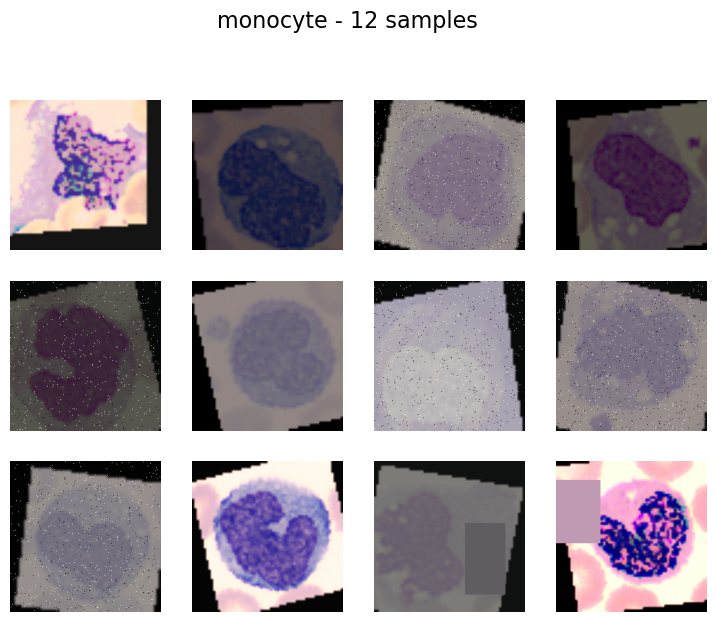

In [98]:
print(LABELS)
show_images_from_class(visual_loader, 'monocyte', LABELS, num_images=12)

# STEP 8: Model Architecture

In [60]:
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(EfficientNetClassifier, self).__init__()
        
        self.backbone = models.efficientnet_b0(pretrained=pretrained)
        # self.backbone = models.efficientnet_b3(pretrained=pretrained)
        num_features = self.backbone.classifier[1].in_features

        self.backbone.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

num_classes = len(LABEL2IDX)

# Create model
model = EfficientNetClassifier(num_classes, pretrained=True)

# Move model to device
model = model.to(device)

# Display model architecture
print(f"Model created with {num_classes} classes")
print(f"Model moved to {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model created with 8 classes
Model moved to cuda
Total parameters: 4,337,540
Trainable parameters: 4,337,540


# STEP 9: Loss Function and Optimizer

In [61]:
# Define loss function
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(LABELS),
    y=LABELS
)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print("Training setup:")
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam (lr=0.001, weight_decay=1e-4)")
print(f"Scheduler: StepLR (step_size=10, gamma=0.1)")

Training setup:
Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001, weight_decay=1e-4)
Scheduler: StepLR (step_size=10, gamma=0.1)


# STEP 10: Training Functions

In [62]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch
    
    Returns:
        Average loss and accuracy for the epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc='Training')
    
    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

In [29]:
def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model for one epoch
    
    Returns:
        Average loss, accuracy, and F1 score for the epoch
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc='Validation')
        
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions for F1 score calculation
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    # Calculate F1 score
    f1_macro = f1_score(all_labels, all_predictions, average='macro')
    f1_weighted = f1_score(all_labels, all_predictions, average='weighted')
    
    return epoch_loss, epoch_acc, f1_macro, f1_weighted

### Load model

In [30]:
# Updated load_model function to return history
def load_model_with_history(model_path, num_classes):
    """
    Load a saved model along with its training history
    """

    model = EfficientNetClassifier(num_classes)

    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    # Extract history if available
    history = checkpoint.get('history', None)
    f1_score = checkpoint.get('f1_score', 0.0)
    
    print(f"Model loaded from {model_path}")
    print(f"Best F1 score: {f1_score:.4f}")
    
    return model, history

# STEP 11: Training Loop

In [31]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    """
    Complete training loop with validation
    
    Returns:
        Training history dictionary
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1_macro': [],
        'val_f1_weighted': []
    }
    
    best_f1 = 0.0
    best_model_state = None
    # best_model_state = load_model_with_history('eff_b3.pth', num_classes)
    
    print(f"Starting training for {num_epochs} epochs...")
    print("-" * 50)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation
        val_loss, val_acc, val_f1_macro, val_f1_weighted = validate_epoch(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step()
        
        # Save best model
        if val_f1_weighted > best_f1:
            best_f1 = val_f1_weighted
            best_model_state = model.state_dict().copy()
            print(f"New best F1 score: {best_f1:.4f} F1_weighted, saving model state")
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(val_f1_macro)
        history['val_f1_weighted'].append(val_f1_weighted)
        
        # Print epoch results
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Val F1 (Macro): {val_f1_macro:.4f}, Val F1 (Weighted): {val_f1_weighted:.4f}')
        print(f'Current LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print("-" * 50)
        
        # Early stopping check
        if epoch > 10 and val_f1_macro < max(history['val_f1_weighted'][-10:]) - 0.01:
            print("Early stopping triggered!")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Best model loaded with F1 score: {best_f1:.4f}")
    
    return history

In [63]:
# Start training
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15)

Starting training for 15 epochs...
--------------------------------------------------
Epoch 1/15


Validation: 100%|██████████| 59/59 [00:04<00:00, 12.57it/s, Loss=0.1808, Acc=92.38%]


New best F1 score: 0.9237 F1_weighted, saving model state
Train Loss: 0.6644, Train Acc: 78.08%
Val Loss: 0.2287, Val Acc: 92.38%
Val F1 (Macro): 0.8675, Val F1 (Weighted): 0.9237
Current LR: 0.001000
--------------------------------------------------
Epoch 2/15


Validation: 100%|██████████| 59/59 [00:04<00:00, 12.39it/s, Loss=0.2895, Acc=93.18%]


New best F1 score: 0.9289 F1_weighted, saving model state
Train Loss: 0.3862, Train Acc: 86.58%
Val Loss: 0.1954, Val Acc: 93.18%
Val F1 (Macro): 0.8555, Val F1 (Weighted): 0.9289
Current LR: 0.001000
--------------------------------------------------
Epoch 3/15


Validation: 100%|██████████| 59/59 [00:04<00:00, 12.42it/s, Loss=0.2320, Acc=92.32%]


Train Loss: 0.3206, Train Acc: 88.78%
Val Loss: 0.2184, Val Acc: 92.32%
Val F1 (Macro): 0.8611, Val F1 (Weighted): 0.9260
Current LR: 0.001000
--------------------------------------------------
Epoch 4/15


Validation: 100%|██████████| 59/59 [00:04<00:00, 12.46it/s, Loss=0.0410, Acc=96.11%]


New best F1 score: 0.9607 F1_weighted, saving model state
Train Loss: 0.2708, Train Acc: 90.98%
Val Loss: 0.1225, Val Acc: 96.11%
Val F1 (Macro): 0.9269, Val F1 (Weighted): 0.9607
Current LR: 0.001000
--------------------------------------------------
Epoch 5/15


Validation: 100%|██████████| 59/59 [00:04<00:00, 12.52it/s, Loss=0.0733, Acc=95.68%]


Train Loss: 0.2604, Train Acc: 91.18%
Val Loss: 0.1285, Val Acc: 95.68%
Val F1 (Macro): 0.9257, Val F1 (Weighted): 0.9568
Current LR: 0.001000
--------------------------------------------------
Epoch 6/15


Validation: 100%|██████████| 59/59 [00:04<00:00, 12.42it/s, Loss=0.2491, Acc=92.54%]


Train Loss: 0.2312, Train Acc: 92.07%
Val Loss: 0.2088, Val Acc: 92.54%
Val F1 (Macro): 0.8961, Val F1 (Weighted): 0.9243
Current LR: 0.001000
--------------------------------------------------
Epoch 7/15


Validation: 100%|██████████| 59/59 [00:04<00:00, 12.59it/s, Loss=0.1995, Acc=96.06%]


New best F1 score: 0.9607 F1_weighted, saving model state
Train Loss: 0.2203, Train Acc: 92.27%
Val Loss: 0.1211, Val Acc: 96.06%
Val F1 (Macro): 0.9233, Val F1 (Weighted): 0.9607
Current LR: 0.001000
--------------------------------------------------
Epoch 8/15


Validation: 100%|██████████| 59/59 [00:04<00:00, 12.30it/s, Loss=0.2402, Acc=94.83%]


Train Loss: 0.2341, Train Acc: 92.31%
Val Loss: 0.1525, Val Acc: 94.83%
Val F1 (Macro): 0.8984, Val F1 (Weighted): 0.9470
Current LR: 0.001000
--------------------------------------------------
Epoch 9/15


Validation: 100%|██████████| 59/59 [00:04<00:00, 12.33it/s, Loss=0.4885, Acc=95.63%]


Train Loss: 0.2104, Train Acc: 92.70%
Val Loss: 0.1412, Val Acc: 95.63%
Val F1 (Macro): 0.9179, Val F1 (Weighted): 0.9552
Current LR: 0.001000
--------------------------------------------------
Epoch 10/15


Validation: 100%|██████████| 59/59 [00:04<00:00, 12.45it/s, Loss=0.1623, Acc=95.63%]


Train Loss: 0.2127, Train Acc: 92.71%
Val Loss: 0.1241, Val Acc: 95.63%
Val F1 (Macro): 0.9240, Val F1 (Weighted): 0.9557
Current LR: 0.000100
--------------------------------------------------
Epoch 11/15


Validation: 100%|██████████| 59/59 [00:04<00:00, 12.36it/s, Loss=0.0402, Acc=97.44%]


New best F1 score: 0.9744 F1_weighted, saving model state
Train Loss: 0.1459, Train Acc: 94.86%
Val Loss: 0.0762, Val Acc: 97.44%
Val F1 (Macro): 0.9511, Val F1 (Weighted): 0.9744
Current LR: 0.000100
--------------------------------------------------
Epoch 12/15


Validation: 100%|██████████| 59/59 [00:04<00:00, 12.38it/s, Loss=0.0168, Acc=97.76%]

New best F1 score: 0.9776 F1_weighted, saving model state
Train Loss: 0.1129, Train Acc: 95.76%
Val Loss: 0.0660, Val Acc: 97.76%
Val F1 (Macro): 0.9604, Val F1 (Weighted): 0.9776
Current LR: 0.000100
--------------------------------------------------
Early stopping triggered!
Best model loaded with F1 score: 0.9776


# STEP 12: Training Visualization

In [27]:
# Option to load model instead of training
USE_SAVED_MODEL = True

if USE_SAVED_MODEL:
    # Load the saved model
    loaded_model, history = load_model_with_history('eff_b3.pth', num_classes)
    model = loaded_model
    
    # If no history available, skip visualization or create dummy
    if history is None:
        print("No training history available - skipping training plots")
        # You can either skip plot_training_history() or create dummy data
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'val_f1_macro': [],
            'val_f1_weighted': []
        }

Model loaded from eff_b3.pth
Best F1 score: 0.9766


In [64]:
def plot_training_history(history):
    """
    Plot training history
    """
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # F1 Score plot
    plt.subplot(1, 3, 3)
    plt.plot(history['val_f1_macro'], label='F1 Macro')
    plt.plot(history['val_f1_weighted'], label='F1 Weighted')
    plt.title('F1 Scores')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

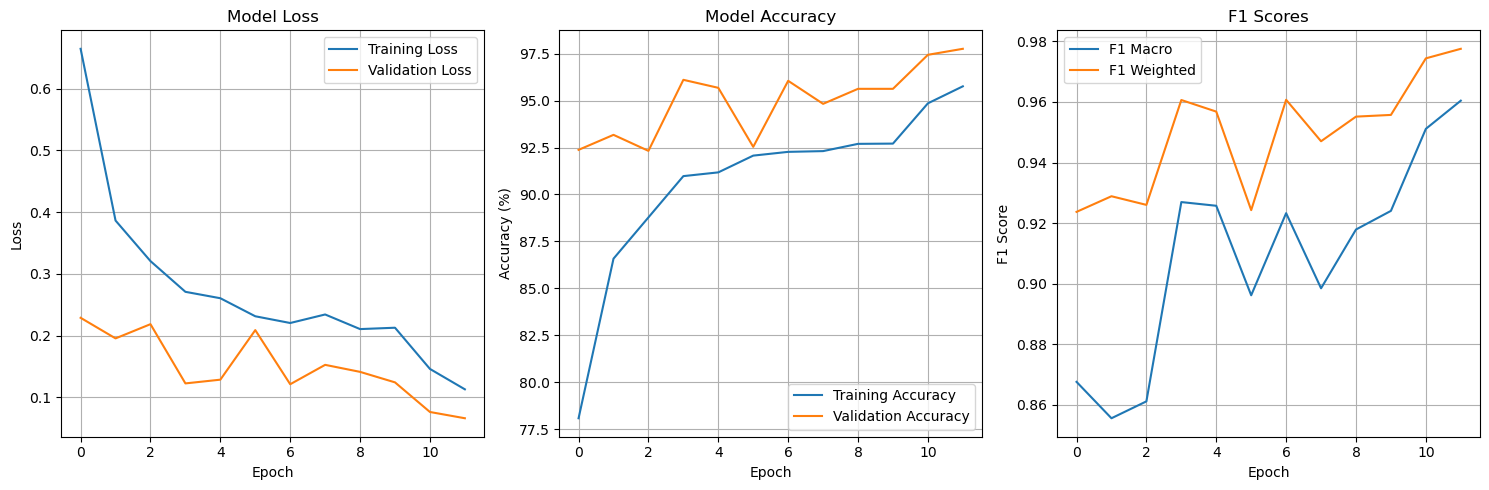

In [65]:
# Plot training history
plot_training_history(history)

# STEP 13: Model Evaluation

In [66]:
def evaluate_model(model, val_loader, device, class_names=None):
    """
    Comprehensive model evaluation: prints F1 scores, classification report,
    confusion matrix, and returns per-class F1 scores along with macro & weighted F1.
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate macro and weighted F1
    f1_macro = f1_score(all_labels, all_predictions, average='macro')
    f1_weighted = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f"Final F1 Score (Macro): {f1_macro:.4f}")
    print(f"Final F1 Score (Weighted): {f1_weighted:.4f}")
    
    # Get classification report as dict
    report_dict = classification_report(all_labels, all_predictions, output_dict=True)
    
    print("\nPer-Class F1 Scores:")
    for cls_idx, metrics in report_dict.items():
        if cls_idx.isdigit():  # Only numeric classes
            label = f"{class_names[int(cls_idx)]}" if class_names else cls_idx
            print(f"Class {label}: F1 Score = {metrics['f1-score']:.4f}")
    
    # Print full classification report
    print("\nFull Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return f1_macro, f1_weighted, all_probabilities, report_dict

Evaluating: 100%|██████████| 59/59 [00:04<00:00, 11.91it/s]


Final F1 Score (Macro): 0.9604
Final F1 Score (Weighted): 0.9776

Per-Class F1 Scores:
Class basophil: F1 Score = 0.9412
Class eosinophil: F1 Score = 0.9942
Class erythroblast: F1 Score = 0.9431
Class immature granulocytes(myelocytes, metamyelocytes and promyelocytes): F1 Score = 0.9595
Class lymphocyte: F1 Score = 0.9508
Class monocyte: F1 Score = 0.9123
Class neutrophil: F1 Score = 0.9839
Class platelet: F1 Score = 0.9985

Full Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.95      0.93      0.94        60
                                                         eosinophil       1.00      0.99      0.99       436
                                                       erythroblast       0.92      0.97      0.94        60
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.95      0.97      0.96       4

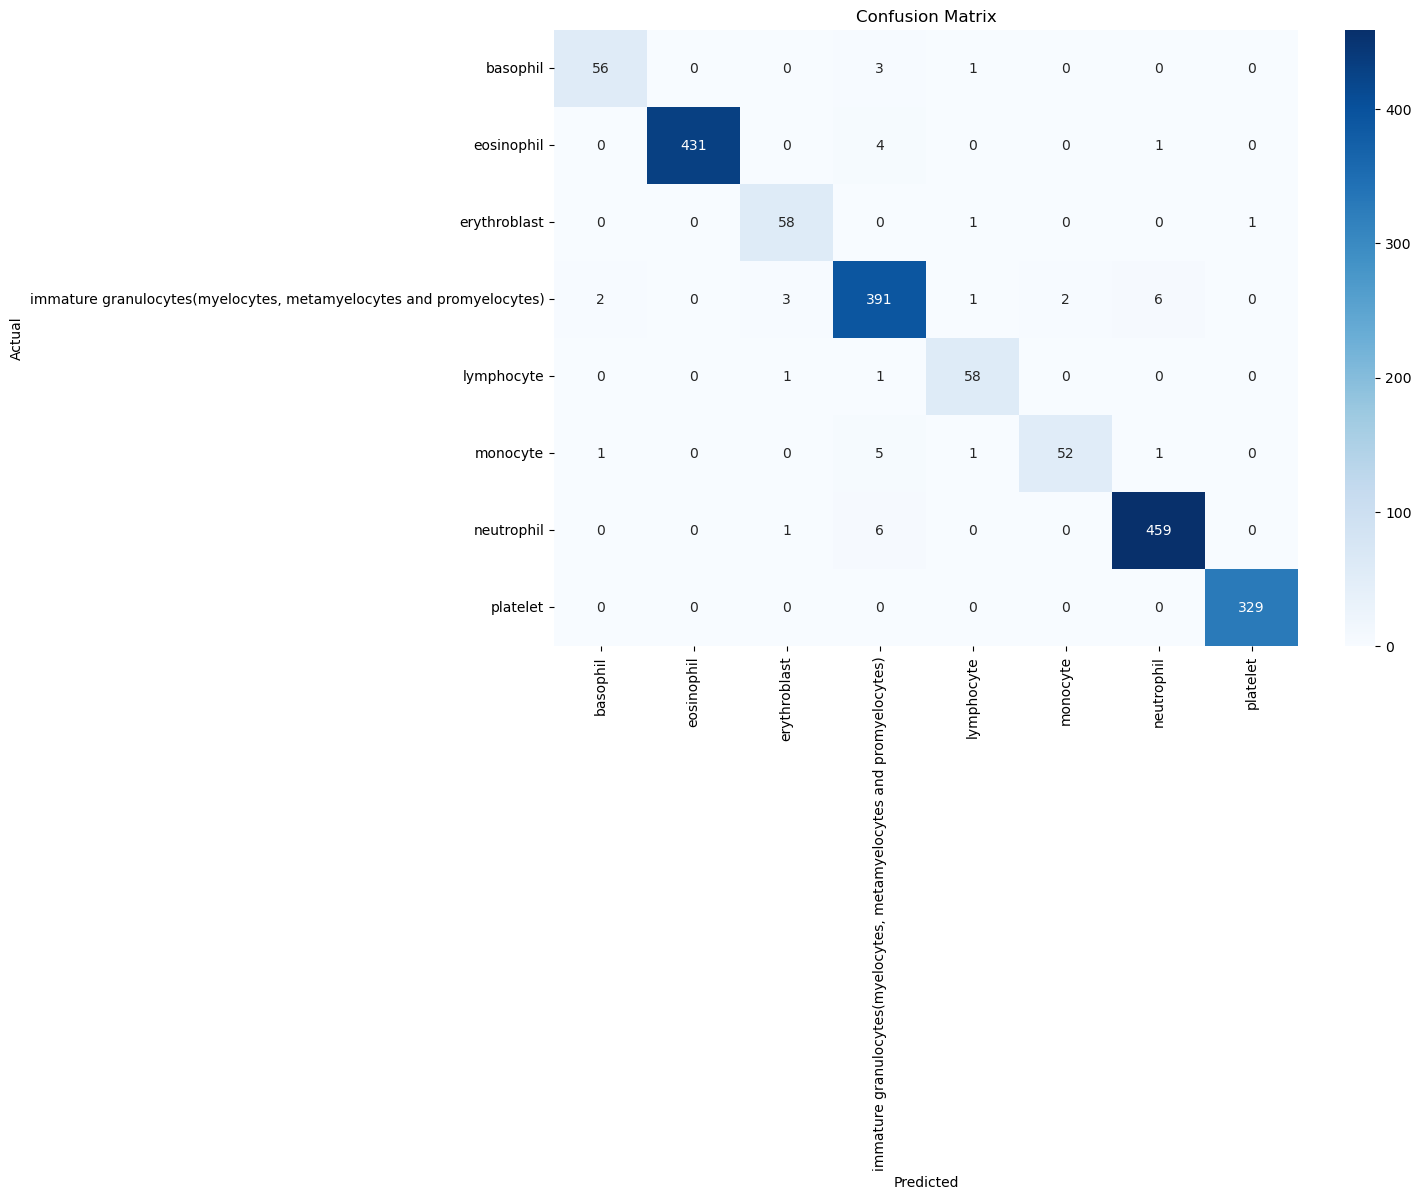

In [67]:
f1_macro, f1_weighted, all_probs, report_dict = evaluate_model(model, val_loader, device, class_names=LABELS)

# STEP 14: Test Data Prediction

In [68]:
def zclassifier_predict(model, data_loader, device):
    """
    Zclassifier prediction method - uses max logit values for confidence scoring
    """
    model.eval()
    all_predictions = []
    all_confidence_scores = []
    all_logits = []
    
    with torch.no_grad():
        for batch_data in tqdm(data_loader, desc='Zclassifier Prediction'):
            images = batch_data[0].to(device)
            
            # Forward pass - get raw logits
            logits = model(images)
            
            # Use max logit values as confidence scores (Zclassifier approach)
            max_logits, predicted = torch.max(logits, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_confidence_scores.extend(max_logits.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_confidence_scores), np.array(all_logits)

In [69]:
print("Making predictions on test data using Zclassifier...")
test_predictions, test_logit_scores, test_all_logits = zclassifier_predict(model, test_loader, device)

Making predictions on test data using Zclassifier...


Zclassifier Prediction: 100%|██████████| 107/107 [00:08<00:00, 12.40it/s]


# STEP 16: Create Submission File

In [70]:
def create_submission(test_dataset, predictions, output_file="submission.csv"):
    """
    Create submission file for the blood cell classification task.
    
    Args:
        test_dataset: ArtDataset instance for test data
        predictions: Array of predicted class indices
        output_file: Output CSV filename
        unknown_label: Label for unknown/out-of-distribution samples
    """
    submission_data = []

    for i in range(len(test_dataset)):
        filename = test_dataset.data.iloc[i]['filename']
        pred_class_id = predictions[i]

        submission_data.append({
            "filename": filename,
            "label": pred_class_id
        })

    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv(output_file, index=False)
    print(f"Saved submission to {output_file}")
    print(f"Submission shape: {submission_df.shape}")
    print("Sample predictions:")
    print(submission_df.head())

    return submission_df

In [71]:
# Create submission file
submission = create_submission(test_dataset, test_predictions, output_file="submission_b0_augment_color.csv")

Saved submission to submission_b0_augment_color.csv
Submission shape: (3421, 2)
Sample predictions:
                                       filename  label
0  2ee2e141028805de9689b1299f40d4f4c3020175.png      3
1  f93145579d7f56c2822cde2f541de2564b9cdaed.png      0
2  543f214ff2cdd6ba2aedefc4e5c54b4294340cba.png      1
3  3fb480e163ef8f3f0734e5384d1dbe25c8349cda.png      1
4  cf8c0f32908617ba36590366c9b76c100792d09d.png      1


In [72]:
# Load the CSV
submission_dataset = pd.read_csv("submission_b0_augment_color.csv")

In [73]:
print(submission_dataset['label'].value_counts())

label
7    748
6    664
1    605
3    565
2    312
5    179
0    177
4    171
Name: count, dtype: int64


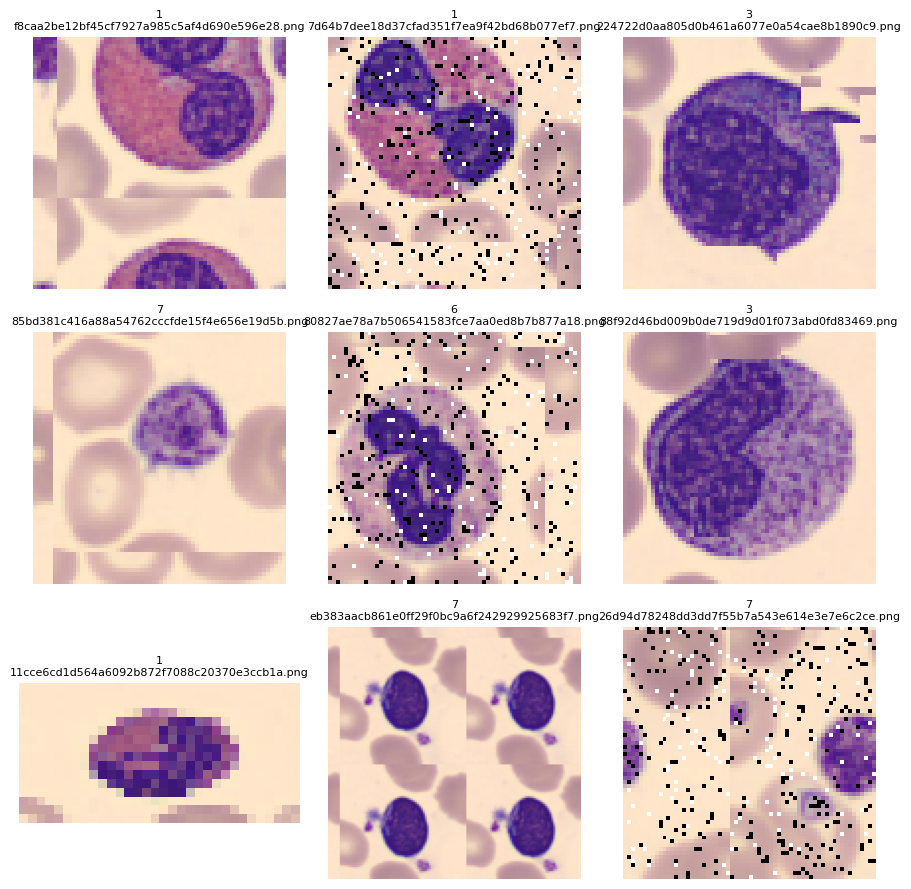

In [74]:
# Sample a few rows (you can adjust n)
sampled_df = submission_dataset.sample(n=9).reset_index(drop=True)

# Plot settings
plt.figure(figsize=(9, 9))  # Adjust size as needed

for i, row in sampled_df.iterrows():
    uuid = row['filename']
    style = row['label']

    # Try PNG then JPG fallback
    img_path = os.path.join(TEST_DIR, f"{uuid}")
    image = Image.open(img_path)
    # Plot
    plt.subplot(3, 3, i + 1)  # 3 rows, 3 cols
    plt.imshow(image)
    plt.title(f"{style}\n{uuid}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

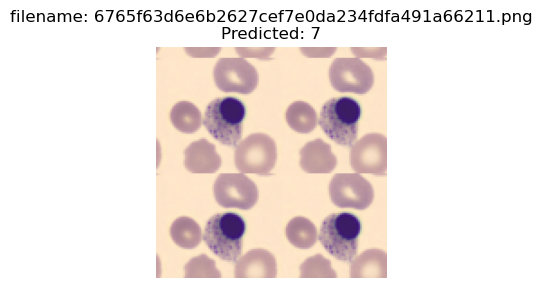

Logit scores for this image:
0: -3.5044
1: -2.0494
2: -2.4910
3: -4.5659
4: -4.9233
5: 0.7990
6: 0.8029
7: 1.5530
7 : 1.5529671907424927


In [75]:
logits_df = pd.DataFrame(test_all_logits, columns=LABELS)
logits_df['filename'] = submission_dataset['filename']
logits_df['predicted_style'] = submission_dataset['label']

# Pick a random row
row = logits_df.sample(1).iloc[0]

# row = logits_df.loc[logits_df.predicted_style == '0'].sample(1).iloc[0]

# filename ='108edc72-7363-4995-b14b-390057594f5e'
# row = logits_df.loc[logits_df.filename == filename].iloc[0]

# Show image
filename = row['filename']
image_path = f"./competition/test/{filename}"
img = Image.open(image_path)

plt.figure(figsize=(3,3))
plt.imshow(img)
plt.axis("off")
plt.title(f"filename: {filename}\nPredicted: {row['predicted_style']}")
plt.show()

# Print logits
print("Logit scores for this image:")
m = [0, ""]
for label in IDX2LABEL:
    if (row[label] > m[0]):
        m[0] = row[label]
        m[1] = label
    print(f"{label}: {row[label]:.4f}")
print(f"{m[1]} : {m[0]}")

# STEP 17: Model Saving and Loading

In [67]:
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_classes': num_classes,
    'f1_score': f1_weighted,
    'history': history
}, 'eff_b0_augment_gamma_2.pth')